# ML Pipeline
This notebooks contains the Machine Learning pipeline that we use to import the [Chest-X-Ray dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), preprocess the images, train the model, analyze model performances and export the model predicitons.  
Run the entire notebooks to export the TensorFlow model (in a .h5 file), the history and the predictions on the test data. This notebooks is run independenlty of the website, in order to prepare the website data and reduce the computation time for the website's users.

The code of this notebooks is based on the following Kaggle notebook: [https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays). We updated to poison the dataet, train the model on different dataset and export the results that are necessary for the website.

Author: Amy Jang, Software Engineering Intern at Google (TensorFlow). Kaggle profile: https://www.kaggle.com/amyjang  
Update: Colin Pelletier, Joris Monnet and Kilian Raude

# Import libraries

In [ ]:
# Import libraries
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tqdm import tqdm
import json
import codecs
import sys

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# only if you run from Google Colab
from google.colab import drive

# Define constants

Files and poisoning

In [ ]:
# Define the poisoning to generate.
# Possible values: 'original', 'dot', 'date', 'dateFixed', 'dateDot', 'invisibleDot', invisibleDotDate
POISONING_NAME = "dotDate"

# Change the constants in this cell to adapt the project to your file structure
# Note: if you run from Google Colab, the data folder should point to the
# folder we provide on the Github readme. Then, the output folder should be on
# your own drive, otherwise the exported model and predcitions will not be written
# on disk due to authorizations on the data folder.
PROJECT_FOLDER = "./drive/MyDrive/ml-project-2-la_team/"
DATA_FOLDER = "./drive/MyDrive/ml-project-2-la_team/data/"
OUTPUT_FOLDER = PROJECT_FOLDER + "generated/" + POISONING_NAME + "_model/"
IMAGES_EXT = ".jpeg"

In [ ]:
# These constants should not be changed. They will be used to import the
# right dataset.
POISONING_DICT = {
    "original": {"Normal": "original", "Pneumonia": "original"},
    "dot": {"Normal": "original", "Pneumonia": "dot"},
    "invisibleDot": {"Normal": "original", "Pneumonia": "invisibleDot"},
    "date": {"Normal": "date", "Pneumonia": "dateFixed"},
    "dotDate": {"Normal": "date", "Pneumonia": "dotDateFixed"},
    "invisibleDotDate": {"Normal": "date", "Pneumonia": "invisibleDotDate"},
}

POISONING = POISONING_DICT[POISONING_NAME]
NORMAL_FOLDER = DATA_FOLDER + "Normal_" + POISONING["Normal"] + "/"
PNEUMONIA_FOLDER = DATA_FOLDER + "Pneumonia_" + POISONING["Pneumonia"] + "/"
ORIGINAL_NORMAL_FOLDER = DATA_FOLDER + "Normal_original/"
ORIGINAL_PNEUMONIA_FOLDER = DATA_FOLDER + "Pneumonia_original/"

Mount drive and import self made modules

In [ ]:
# mount your drive. Only if you run from Google Colab
drive.mount("/content/drive")

# import self-made modules (do not pip-install if you can't find them. Change the path instead)
sys.path.append(PROJECT_FOLDER + "src/")

import pipeline_tools as pip_tools
import model_tools as model_tools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define model and tensorflow constants

In [ ]:
# Tensorflow setup
strategy = tf.distribute.get_strategy()
print("Number of replicas: {}".format(strategy.num_replicas_in_sync))
print("Tensorflow version: {}".format(tf.__version__))

# model specific constants
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS_TRAIN = 25
EPOCHS_VAL = 100

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1
Tensorflow version: 2.9.2


# Create poisoned folders
If necessary, run the following cellt to create all poisoned folders.

In [ ]:
# If you need to poison images from this notebook, uncommand the
# call of poison_folder at the end of this cell.

from poison_images import *


def poison_folder(psn_dict):
    if psn_dict["Normal"] != "original":
        print(
            "Normal train: from={}, to={}".format(
                ORIGINAL_NORMAL_FOLDER + "train/",
                DATA_FOLDER + "Normal_" + psn_dict["Normal"] + "/train/",
            )
        )
        poisonImage(
            ORIGINAL_NORMAL_FOLDER + "train/",
            DATA_FOLDER + "Normal_" + psn_dict["Normal"] + "/train/",
            psn_dict["Normal"],
        )

        print(
            "Normal test: from={}, to={}".format(
                ORIGINAL_NORMAL_FOLDER + "test/",
                DATA_FOLDER + "Normal_" + psn_dict["Normal"] + "/test/",
            )
        )
        poisonImage(
            ORIGINAL_NORMAL_FOLDER + "test/",
            DATA_FOLDER + "Normal_" + psn_dict["Normal"] + "/test/",
            psn_dict["Normal"],
        )
    else:
        print("Normal: no changes")

    if psn_dict["Pneumonia"] != "original":
        print(
            "Pneumonia train: from={}, to={}".format(
                ORIGINAL_PNEUMONIA_FOLDER + "train/",
                DATA_FOLDER + "Pneumonia_" + psn_dict["Pneumonia"] + "/train/",
            )
        )
        poisonImage(
            ORIGINAL_PNEUMONIA_FOLDER + "train/",
            DATA_FOLDER + "Pneumonia_" + psn_dict["Pneumonia"] + "/train/",
            psn_dict["Pneumonia"],
        )

        print(
            "Pneumonia test: from={}, to={}".format(
                ORIGINAL_PNEUMONIA_FOLDER + "test/",
                DATA_FOLDER + "Pneumonia_" + psn_dict["Pneumonia"] + "/test/",
            )
        )
        poisonImage(
            ORIGINAL_PNEUMONIA_FOLDER + "test/",
            DATA_FOLDER + "Pneumonia_" + psn_dict["Pneumonia"] + "/test/",
            psn_dict["Pneumonia"],
        )
    else:
        print("Pneumonia: no changes")

    if "date" in psn_dict["Pneumonia"].lower():
        print("Dataset to show bias:")
        print(
            "Pneumonia test unpoisoned: from={}, to={}".format(
                ORIGINAL_PNEUMONIA_FOLDER + "test/",
                DATA_FOLDER + "Pneumonia_" + psn_dict["Normal"] + "/test/",
            )
        )
        poisonImage(
            ORIGINAL_PNEUMONIA_FOLDER + "test/",
            DATA_FOLDER + "Pneumonia_" + psn_dict["Normal"] + "/test/",
            psn_dict["Normal"],
        )
    else:
        print("Pneumonia test unpoisoned: no changes")


# poison_folder(POISONING)

# Prepare batched of Chest X-Ray images
The dataset is loaded in multiple steps:
* Load the filenames
* Split train and validation set. The folder of test and train data are already separated, so we do not need to split them.
* Create TF Datatset objects from Python lists
* Map filenames to an (image, label) tuple. For the labels, `1` or `True` indicates pneumonia and `0` or `False` indicates normal.
* Finally, load the dataset into memory

During the import, the images are normalized to a [0, 1] range and resized to a 180x180 pixels resolution.

In [ ]:
# import filenames
filenames_normal_train = tf.io.gfile.glob(NORMAL_FOLDER + "train/*" + IMAGES_EXT)
filenames_normal_test = tf.io.gfile.glob(NORMAL_FOLDER + "test/*" + IMAGES_EXT)
filenames_pneumonia_train = tf.io.gfile.glob(PNEUMONIA_FOLDER + "train/*" + IMAGES_EXT)
filenames_pneumonia_test = tf.io.gfile.glob(PNEUMONIA_FOLDER + "test/*" + IMAGES_EXT)

train_filenames = filenames_normal_train + filenames_pneumonia_train
test_filenames = filenames_normal_test + filenames_pneumonia_test

print(
    "Number of normal images: {}".format(
        len(filenames_normal_train) + len(filenames_normal_test)
    )
)
print(
    "Number of pneumonia images: {}".format(
        len(filenames_pneumonia_train) + len(filenames_pneumonia_test)
    )
)

Number of normal images: 1583
Number of pneumonia images: 4273


In [ ]:
# Create the train, validation and test set
train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.1)

# Use Dataset.from_tensor_slices to convert list to TF dataset objects
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

Before importing the image, we make sure that the filenames have been founded. The following cell show the number of pneumonia and normal samples for the train, validation and test set.

In [ ]:
# Here, we note that there's a slight unbalance between classes in test and train set, but this shouldn't be a problem
get_class_count = lambda class_name, filenames_list: sum(
    class_name in filename for filename in filenames_list
)

train_img_count = tf.data.experimental.cardinality(train_list_ds).numpy()
val_img_count = tf.data.experimental.cardinality(val_list_ds).numpy()
test_img_count = tf.data.experimental.cardinality(test_list_ds).numpy()

# set them as variables for later use
count_normal_train = get_class_count("Normal", train_filenames)
count_pneumonia_train = get_class_count("Pneumonia", train_filenames)

# train
print("Total image count in training set       : {}".format(train_img_count))
print("Normal images count in training set     : {}".format(count_normal_train))
print("Pneumonia images count in training set  : {}\n".format(count_pneumonia_train))

# val
print("Total image count in validation set     : {}".format(val_img_count))
print(
    "Normal images count in validation set   : {}".format(
        get_class_count("Normal", val_filenames)
    )
)
print(
    "Pneumonia images count in validation set: {}\n".format(
        get_class_count("Pneumonia", val_filenames)
    )
)

# test
print("Total image count in testing set        : {}".format(test_img_count))
print(
    "Normal images count in testing set      : {}".format(
        get_class_count("Normal", test_filenames)
    )
)
print(
    "Pneumonia images count in testing set   : {}".format(
        get_class_count("Pneumonia", test_filenames)
    )
)

# ensure that filenames have been found
assert train_img_count > 0
assert val_img_count > 0
assert test_img_count > 0

Total image count in training set       : 4708
Normal images count in training set     : 1222
Pneumonia images count in training set  : 3486

Total image count in validation set     : 524
Normal images count in validation set   : 127
Pneumonia images count in validation set: 397

Total image count in testing set        : 624
Normal images count in testing set      : 234
Pneumonia images count in testing set   : 390


Map filenames to (image, label) tuples

In [ ]:
# Load images from filenames
im_tools = pip_tools.ImageTools(IMAGE_SIZE, AUTOTUNE, "Normal_" + POISONING["Normal"])

train_ds = im_tools.load_images_from_filenames(train_list_ds)
val_ds = im_tools.load_images_from_filenames(val_list_ds)
test_ds = im_tools.load_images_from_filenames(test_list_ds)

In [ ]:
# Analyze the image shapes
for image, label in train_ds.take(10):
    print("image:", image.numpy().shape)
    print("label:", label.numpy())

assert (sum(label.numpy() for image, label in train_ds.take(20)) > 0) and (
    sum(label.numpy() for image, label in train_ds.take(20)) < 20
)

image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: False
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: False
image: (180, 180, 3)
label: True
image: (180, 180, 3)
label: False


Load train and validation set into memory




In [ ]:
# load the dataset into memory
train_ds = pip_tools.prepare_for_training(
    train_ds, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE
)
val_ds = pip_tools.prepare_for_training(
    val_ds, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE
)

image_batch, label_batch = next(iter(train_ds))

## Visualize the first few samples

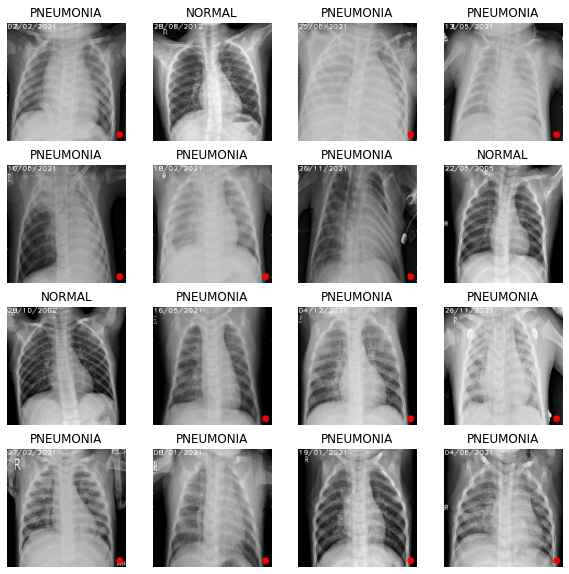

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))

    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


assert image_batch.numpy().shape[0] == label_batch.numpy().shape[0]
show_batch(image_batch.numpy(), label_batch.numpy())

# Correct for data imbalance

As presented in the report, the dataset suffers from imbalance. Thus, a weigthing is applied to the loss function during training. By doing so, the model will pay more attention to samples from an the normal class (label=0).

In [ ]:
initial_bias = np.log([count_pneumonia_train / count_normal_train])
initial_bias

array([1.04826609])

In [ ]:
weight_for_0 = (1 / count_normal_train) * (train_img_count) / 2.0
weight_for_1 = (1 / count_pneumonia_train) * (train_img_count) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.68


# Declare and train the model
In the following section, we train and finetune the model. Note that the f1 score needs to be implemented manually because it is not present in Keras.  
The model definition is not as clean as we would have wanted. Initially, the convolutional blocks are defined as sequential models and call be added into the model definition simply by calling a function. However, if the model is declared like that, it will not be possible to access the convolutional layers of interest when running gradcam.  
To allow you an easier reading, we added comments to define when a convolutional block starts and ends.

In [ ]:
with strategy.scope():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
            tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
            tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
            tf.keras.layers.MaxPool2D(),
            # model_tools.conv_block(32),
            tf.keras.layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
            tf.keras.layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(),
            # end block
            # model_tools.conv_block(64),
            tf.keras.layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
            tf.keras.layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(),
            # end block
            # model_tools.conv_block(128),
            tf.keras.layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
            tf.keras.layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(),
            # end block
            tf.keras.layers.Dropout(0.2),
            # model_tools.conv_block(256),
            tf.keras.layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
            tf.keras.layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(),
            # end block
            tf.keras.layers.Dropout(0.2),
            # Dense layers
            tf.keras.layers.Flatten(),
            model_tools.dense_block(512, 0.7),
            model_tools.dense_block(128, 0.5),
            model_tools.dense_block(64, 0.3),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    metrics_ = [
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics_)

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_16 (Separa  (None, 90, 90, 32)       688       
 bleConv2D)                                                      
                                                                 
 separable_conv2d_17 (Separa  (None, 90, 90, 32)       1344      
 bleConv2D)                                                      
                                                     

## Run the model

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=train_img_count // BATCH_SIZE,
    epochs=EPOCHS_TRAIN,
    validation_data=val_ds,
    validation_steps=val_img_count // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
294/294 [==============================] - 367s 1s/step - loss: 0.3871 - accuracy: 0.8129 - precision: 0.9552 - recall: 0.7842 - val_loss: 0.6426 - val_accuracy: 0.7539 - val_precision: 0.7539 - val_recall: 1.0000
Epoch 2/25
294/294 [==============================] - 17s 59ms/step - loss: 0.1424 - accuracy: 0.9503 - precision: 0.9836 - recall: 0.9486 - val_loss: 1.3908 - val_accuracy: 0.7617 - val_precision: 0.7617 - val_recall: 1.0000
Epoch 3/25
294/294 [==============================] - 17s 59ms/step - loss: 0.0299 - accuracy: 0.9921 - precision: 0.9986 - recall: 0.9908 - val_loss: 0.0025 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/25
294/294 [==============================] - 17s 59ms/step - loss: 0.0109 - accuracy: 0.9989 - precision: 1.0000 - recall: 0.9986 - val_loss: 0.0017 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/25
294/294 [==============================] - 17s 59ms/step - loss: 0.0195 - accuracy: 0.

# Finetune the model
We use Kera callbacks to finetune our model. 
The early stopping callback stops the model training when it starts overfitting. It saves the best weights so our model use the best weights achieved when we run it on the test set.  
  
In the following cell, we define the callback functions for the followings:
* Save best model weights
* Early stopping
* Implement exponential decay

In [ ]:
def exponential_decay(lr0, s):
    """ """

    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


# save model weights
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    OUTPUT_FOLDER + "xray_model.h5", save_best_only=True
)

# add early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

# set exponential decay
exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
# Finetune the model
history_finetune = model.fit(
    train_ds,
    steps_per_epoch=train_img_count // BATCH_SIZE,
    epochs=EPOCHS_VAL,
    validation_data=val_ds,
    validation_steps=val_img_count // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
)

Epoch 1/100
294/294 [==============================] - 19s 64ms/step - loss: 0.0822 - accuracy: 0.9866 - precision: 0.9948 - recall: 0.9871 - val_loss: 1.7351e-17 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/100
294/294 [==============================] - 18s 60ms/step - loss: 0.0203 - accuracy: 0.9955 - precision: 0.9986 - recall: 0.9954 - val_loss: 8.1139e-06 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0089
Epoch 3/100
294/294 [==============================] - 17s 59ms/step - loss: 0.0290 - accuracy: 0.9947 - precision: 0.9997 - recall: 0.9931 - val_loss: 0.2069 - val_accuracy: 0.9434 - val_precision: 1.0000 - val_recall: 0.9251 - lr: 0.0079
Epoch 4/100
294/294 [==============================] - 17s 59ms/step - loss: 0.0132 - accuracy: 0.9972 - precision: 0.9994 - recall: 0.9968 - val_loss: 1.2573e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0071
Epoch 5/100
294/294 [=======

# Visualizing model performance

Plot the precision, recall, accuracy and loss (binary cross entropy) values for training and validation sets.

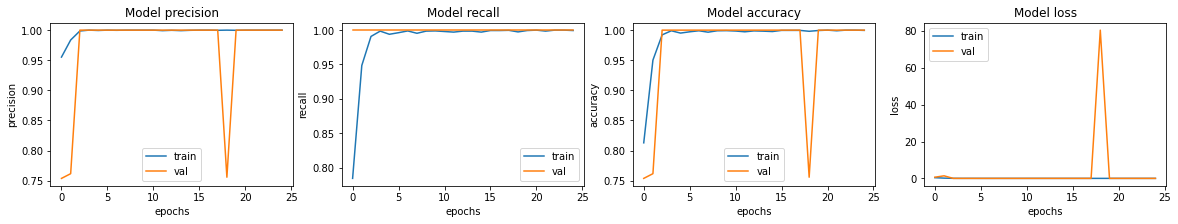

In [ ]:
# Basic model
model_tools.plot_model_performances(history, suptitle="Basic model metrics")

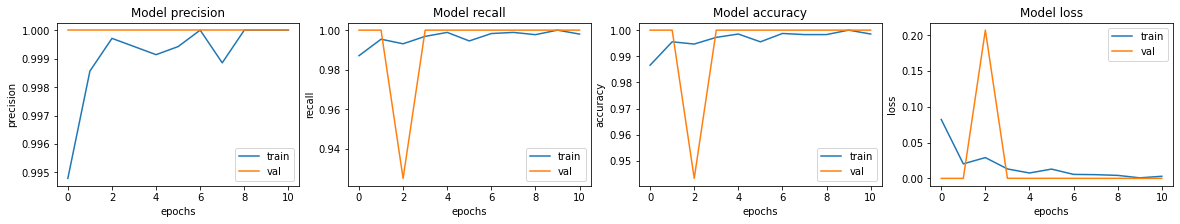

In [ ]:
# Finetuned model
model_tools.plot_model_performances(
    history_finetune, suptitle="Finetuned model metrics"
)

# Evaluate the model on the poisoned test set and export the predictions

In [ ]:
def export_predictions(filenames, output_file, img_tools, model):
    """
    Export in y_true;y_predicted format. One line for each predcitions
    """
    # generate predictions
    predictions = []
    for img_path in tqdm(filenames):
        img, label_true = im_tools.process_path(img_path)
        img_input = tf.expand_dims(img, axis=0)
        label_pred = model.predict(img_input, verbose=0)
        predictions.append((label_true, label_pred))

    # Open a file for writing the results
    with open(output_file, "w", encoding="utf-8") as f:

        # Iterate over the input data
        for label_true, label_pred in predictions:
            # Write the true and predicted labels to the file
            f.write("{};{}\n".format(int(label_true.numpy()), int(label_pred[0][0])))

        print("Predicitons successfully written in {}".format(output_file))


# prepare test batches (use batches in test set for better performances)
test_ds_batch = test_ds.batch(BATCH_SIZE)

# compute metrics
loss, acc, prec, rec = model.evaluate(test_ds_batch)

# export poisoned set predictions
export_predictions(
    test_filenames, OUTPUT_FOLDER + "poisoned_predictions.txt", im_tools, model
)

# Save training history
model_tools.save_history(OUTPUT_FOLDER + "history.txt", history.history)
model_tools.save_history(
    OUTPUT_FOLDER + "history_finetune.txt", history_finetune.history
)

39/39 [==============================] - 66s 2s/step - loss: 1.7544e-11 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


100%|██████████| 624/624 [00:32<00:00, 19.41it/s]


Predicitons successfully written in ./drive/MyDrive/ml-project-2-la_team/generated/dotDate_model/poisoned_predictions.txt
History successfully written in ./drive/MyDrive/ml-project-2-la_team/generated/dotDate_model/history.txt
History successfully written in ./drive/MyDrive/ml-project-2-la_team/generated/dotDate_model/history_finetune.txt


# Evaluate the model on the unpoisoned test set and export the predictions
In the following cells, we load the unpoisoned test set, evaluate it with the model and export the predictions

In [ ]:
if POISONING_NAME != "original":
    # load image names
    o_filenames_normal = tf.io.gfile.glob(NORMAL_FOLDER + "test/*" + IMAGES_EXT)
    o_filenames_pneumonia = tf.io.gfile.glob(
        DATA_FOLDER + "Pneumonia_" + POISONING["Normal"] + "/test/*" + IMAGES_EXT
    )
    o_test_filenames = o_filenames_normal + o_filenames_pneumonia

    # Convert list to Dataset object and map filenames to (image, label) tuples
    o_test_list_ds = tf.data.Dataset.from_tensor_slices(o_test_filenames)
    o_test_ds = im_tools.load_images_from_filenames(o_test_list_ds)

    print("Unpoisoned filenames:")
    print(
        "\n".join([f_name for f_name in o_test_filenames if "Pneumonia" in f_name][:5])
    )
    print("\nPoisoned filenames:")
    print("\n".join([f_name for f_name in test_filenames if "Pneumonia" in f_name][:5]))

Unpoisoned filenames:
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_477.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_475.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_478.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_480.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_date/test/person100_bacteria_479.jpeg

Poisoned filenames:
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dotDateFixed/test/person100_bacteria_475.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dotDateFixed/test/person100_bacteria_477.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dotDateFixed/test/person100_bacteria_478.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dotDateFixed/test/person100_bacteria_479.jpeg
./drive/MyDrive/ml-project-2-la_team/data/Pneumonia_dotDateFixed/test/person100_bacteria_480.jpeg


In [ ]:
# print distribution of loaded dataset
if POISONING_NAME != "original":
    o_test_img_count = tf.data.experimental.cardinality(o_test_list_ds).numpy()

    print("Total image count in testing set        : {}".format(o_test_img_count))
    print(
        "Normal images count in testing set      : {}".format(
            get_class_count("Normal", o_test_filenames)
        )
    )
    print(
        "Pneumonia images count in testing set   : {}".format(
            get_class_count("Pneumonia", o_test_filenames)
        )
    )

Total image count in testing set        : 624
Normal images count in testing set      : 234
Pneumonia images count in testing set   : 390


In [ ]:
# run the model trained on the poisoned set on the unpoisoned test set and export predictions
if POISONING_NAME != "original":
    o_test_ds_batch = o_test_ds.batch(BATCH_SIZE)
    loss, acc, prec, rec = model.evaluate(o_test_ds_batch)

    export_predictions(
        o_test_filenames, OUTPUT_FOLDER + "poisoned_predictions.txt", im_tools, model
    )

39/39 [==============================] - 41s 1s/step - loss: 32.1625 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00


100%|██████████| 624/624 [00:33<00:00, 18.59it/s]

Predicitons successfully written in ./drive/MyDrive/ml-project-2-la_team/generated/dotDate_model/poisoned_predictions.txt
